# IMPORTS

In [132]:
# !pip install lightgbm
# !pip install pandas_ta
# !pip install pandas_ta --no-index --find-links=file:///kaggle/input/pandas-ta/

In [133]:
import pandas as pd
import numpy as np
import os
import random
from lightgbm import LGBMRegressor
import pandas_ta as ta

# CONSTANTS

In [134]:
# TODO: make total calculation
NUMBER_OF_STABLE_STOCKS = 370
NUMBER_OF_DAILY_CHOSEN_STOCKS = 15
DAYS_PERIODS = [10, 21, 63]

# FUNCTIONS

In [135]:
def get_stocks_traded_every_day(stock_prices_df):
    """Return stocks that are traded in every trading day in data and remove others"""
    traded_stock_per_date = stock_prices_df['Date'].value_counts()
    stocks_by_descending_trade_count = stock_prices_df['SecuritiesCode'].value_counts()
    return stocks_by_descending_trade_count[stocks_by_descending_trade_count == len(traded_stock_per_date)].index.values


def adjust_prices(df):
    def calculate_adjusted(df):
        """apply AdjustmentFactor on columns"""
        new = df.sort_index(ascending=False)
        split_coef = new['AdjustmentFactor'].shift(1).fillna(1).cumprod()
        new['adj_open'] = new['Open'] / split_coef
        new['adj_close'] = new['Close'] / split_coef
        new['adj_volume'] = split_coef * new['Volume']
        return new.sort_index(ascending=True)

    df = df.groupby('SecuritiesCode').apply(calculate_adjusted).reset_index(drop=True)
    df.set_index('Date', inplace=True)

    return df


get_daily_change_in_price = lambda df: df.groupby('SecuritiesCode')['adj_close'].apply(lambda x: x.diff() / x)

get_gap_from_market = lambda df: df['daily_change'] - df['market_change_mean']


def get_features_for_prediction(df):
    """
    Args:
        df (pd.DataFrame)  : pd.DataFrame include stock_price
        code (int)  : A local code for a listed company
    Returns:
        feats DataFrame (pd.DataFrame)
    """
    result = []

    for code in df['SecuritiesCode'].unique():
        feats = df.loc[df['SecuritiesCode'] == code, ['SecuritiesCode', 'Target', 'adj_close', 'adj_volume']].copy()

        for period in DAYS_PERIODS:
            feats[f'return_{period}_days'] = feats['adj_close'].pct_change(period)
            feats[f'volume_{period}_days'] = feats['adj_volume'].pct_change(period)
            feats[f'ema_{period}_days'] = ta.ema(feats['adj_close'], length=period + 1)

        # filling data for nan and inf
        feats['adj_volume'] = feats['adj_volume'].fillna(0)
        feats = feats.replace([np.inf, -np.inf], 0)
        result.append(feats)

    return pd.concat(result)


def random_split_of_list_into_halves(l: list) -> [list, list]:
    random.shuffle(l)
    return l[:int(len(l) / 2)], l[int(len(l) / 2):]


def set_rank(df):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with rank
    """
    # set 'Rank' starting from 0
    df.loc[:, 'Rank'] = np.arange(len(df))
    return df


def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """

    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()

    return sharpe_ratio

# PROCESS DATA

In [136]:
train_stock_prices = pd.read_csv(
    os.path.join('../input/jpx-tokyo-stock-exchange-prediction/train_files', 'stock_prices.csv'))
supplemental_stock_prices = pd.read_csv(
    os.path.join('../input/jpx-tokyo-stock-exchange-prediction/supplemental_files', 'stock_prices.csv'))

# our training data and test data concatenated
stock_prices = pd.concat([train_stock_prices, supplemental_stock_prices])

In [137]:
delisted_stocks = stock_prices[stock_prices['SupervisionFlag'] == True]['SecuritiesCode'].values
daily_traded_stocks = get_stocks_traded_every_day(stock_prices)

In [138]:
# TODO: make set and subtract
daily_traded_stocks = [x for x in daily_traded_stocks if (x not in delisted_stocks)]
print(
    f'We now have {len(daily_traded_stocks)} stocks which have available information in every trading day and which are NOT delisted.\n'
    'These remaining stocks are the ones we are going to analyze and "play" with from now on.')

We now have 1845 stocks which have available information in every trading day and which are NOT delisted.
These remaining stocks are the ones we are going to analyze and "play" with from now on.


In [139]:
listed_stock_prices = stock_prices.loc[
    stock_prices['SecuritiesCode'].isin(daily_traded_stocks), ['Date', 'SecuritiesCode', 'Open', 'Close', 'Volume',
                                                               'AdjustmentFactor', 'Target']]

# x daily-traded & listed stocks * 1202 trading days = y rows
assert len(listed_stock_prices) == len(daily_traded_stocks) * len(stock_prices['Date'].unique())

In [140]:
adjusted_prices_df = adjust_prices(listed_stock_prices)
adjusted_prices_df = adjusted_prices_df.sort_values(['SecuritiesCode', 'Date'], ascending=[True, True])
adjusted_prices_df['daily_change'] = get_daily_change_in_price(adjusted_prices_df)

In [141]:
market_change_mean = adjusted_prices_df.groupby('Date')['daily_change'].mean()
market_change_mean = market_change_mean.rename('market_change_mean')

In [142]:
all_stocks_df = adjusted_prices_df.join(market_change_mean, on='Date')
all_stocks_df['market_gap'] = get_gap_from_market(all_stocks_df)

In [143]:
statistics_df = all_stocks_df.groupby(by='SecuritiesCode')['market_gap'].agg(['mean', 'median', 'std'])
statistics_df['abs_mean'] = np.abs(statistics_df['mean'])
statistics_df.sort_values(by=['abs_mean', 'std'], ascending=True, inplace=True)

                    mean    median       std  abs_mean
SecuritiesCode                                        
6986           -0.000003 -0.000033  0.022512  0.000003
6157           -0.000003 -0.000441  0.052177  0.000003
6594            0.000005  0.000557  0.051656  0.000005
4733           -0.000006  0.000843  0.054603  0.000006
8714           -0.000010 -0.000675  0.022756  0.000010


<AxesSubplot:>

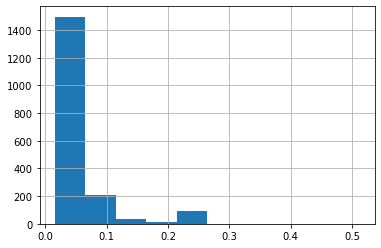

In [144]:
print(statistics_df.head())
statistics_df['std'].hist()

The stocks with std around 0 (+-) are those that behave LIKE THE MARKET.
We want them to be part of our prediction because they are the least-noisy stocks.

Also, get all non-stable stocks ("extreme" stocks):
These are the stocks from which we want to get the ones which are better/worse than the market

In [145]:
stable_stocks_statistics_df = statistics_df[:NUMBER_OF_STABLE_STOCKS]
extreme_stocks_statistics_df = statistics_df[NUMBER_OF_STABLE_STOCKS:]

In [146]:
stable_stocks_df = all_stocks_df[all_stocks_df['SecuritiesCode'].isin(stable_stocks_statistics_df.index)]

"Top": the stocks which are usually "better" then the market in terms of daily_change (on average)
"Bottom": the stocks which are usually "worse" then the market in terms of daily_change (on average)

In [147]:
print(
    f"There are {len(extreme_stocks_statistics_df[extreme_stocks_statistics_df['mean'] > 0])} top_stocks and {len(extreme_stocks_statistics_df[extreme_stocks_statistics_df['mean'] < 0])} bottom_stocks")

There are 1086 top_stocks and 389 bottom_stocks


## Generate features:

In [148]:
len(set(extreme_stocks_statistics_df.index)) + len(set(stable_stocks_statistics_df.index))

1845

In [149]:
extreme_stocks_df = all_stocks_df[all_stocks_df['SecuritiesCode'].isin(set(extreme_stocks_statistics_df.index))]

In [150]:
extreme_stocks_features_df = get_features_for_prediction(extreme_stocks_df)
extreme_stocks_features_df = extreme_stocks_features_df.sort_values(by=['SecuritiesCode', 'Date'])

In [151]:
extreme_stocks_features_df

,SecuritiesCode,Target,adj_close,adj_volume,return_10_days,volume_10_days,ema_10_days,return_21_days,volume_21_days,ema_21_days,return_63_days,volume_63_days,ema_63_days
Date,,,,,,,,,,,,,
2017-01-04,1301,0.000730,2742.0,31400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,1301,0.002920,2738.0,17900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,1301,-0.001092,2740.0,19900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,1301,-0.005100,2748.0,24200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,1301,-0.003295,2745.0,9300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,9997,-0.013783,664.0,177600.0,-0.073919,0.107923,674.880939,-0.086657,0.903537,690.978755,-0.103914,-0.001686,709.320477
2022-05-24,9997,0.006211,653.0,191600.0,-0.081575,-0.341581,671.234115,-0.096819,1.551265,687.676255,-0.118758,0.515823,707.587539
2022-05-25,9997,0.004630,644.0,233300.0,-0.083926,0.054702,666.695096,-0.117808,1.007745,683.878320,-0.111724,-0.233070,705.631000


# MODEL

In [152]:
LGBM_PARAMS = {
    'seed': 42,
    'n_jobs': -1,
}

FEATURE_COLUMNS = [
    'return_10_days',
    'volume_10_days',
    'ema_10_days',
    'return_21_days',
    'volume_21_days',
    'ema_21_days',
    'return_63_days',
    'volume_63_days',
    'ema_63_days'
]

In [153]:
def get_features_and_label(df):
    """
    Args:
        df (pd.DataFrame): loaded price data with features
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # split data into TRAIN and TEST
    TRAIN_END = "2021-12-03"
    # We put a week gap between TRAIN_END and TEST_START
    # to avoid leakage of test data information from label
    TEST_START = "2021-12-06"

    # to store splited data
    trains_X, tests_X = [], []
    trains_y, tests_y = [], []

    # generate feature one by one
    for code in df['SecuritiesCode'].unique():
        feats = df[df['SecuritiesCode'] == code].dropna().drop(columns='Target')
        labels = df.loc[df['SecuritiesCode'] == code, ['SecuritiesCode', 'Target']].dropna()

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # align label and feature indexes
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]

            assert (labels.loc[:, 'SecuritiesCode'] == feats.loc[:, 'SecuritiesCode']).all()
            labels = labels['Target']

            # split data into TRAIN and TEST
            _train_X = feats[:TRAIN_END]
            _test_X = feats[TEST_START:]

            _train_y = labels[:TRAIN_END]
            _test_y = labels[TEST_START:]

            assert len(_train_X) == len(_train_y)
            assert len(_test_X) == len(_test_y)

            # store features
            trains_X.append(_train_X)
            tests_X.append(_test_X)
            # store labels
            trains_y.append(_train_y)
            tests_y.append(_test_y)

    # combine features for each codes
    train_X = pd.concat(trains_X)
    test_X = pd.concat(tests_X)
    # combine label for each codes
    train_y = pd.concat(trains_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, test_X, test_y


def get_daily_ranked_results(df: pd.DataFrame) -> [pd.DataFrame, pd.DataFrame]:
    # generate feature/label
    train_X, train_y, test_X, test_y = get_features_and_label(df)
    # initialize model
    pred_model = LGBMRegressor(**LGBM_PARAMS)
    # train
    pred_model.fit(train_X[FEATURE_COLUMNS].values, train_y)
    # prepare result data
    result = test_X[['SecuritiesCode']].copy()
    # predict
    result.loc[:, 'predict'] = pred_model.predict(test_X[FEATURE_COLUMNS])
    # actual result
    result.loc[:, 'Target'] = test_y.values
    # sort results by date and ascending/descending "predict", depending on which group we want:
    # the higher the "predict" the more likely to BUY the stock
    # the lower the "predict" the more likely to SELL the stock
    result = result.sort_values(['Date', 'predict'], ascending=[True, False])
    # set_rank
    ranked_results = result.groupby('Date').apply(set_rank)
    # Drop unnecessary columns. Keep only those which are relevant for submission:
    ranked_results_no_labels_df = ranked_results.drop(columns=['predict'])

    group = ranked_results_no_labels_df.groupby('Date')
    return [group.head(NUMBER_OF_DAILY_CHOSEN_STOCKS), group.tail(NUMBER_OF_DAILY_CHOSEN_STOCKS)]

In [154]:
top_daily_chosen_stocks_df, bottom_daily_chosen_stocks_df = get_daily_ranked_results(extreme_stocks_features_df)

In [156]:
def get_final_ranks_df(top_df: pd.DataFrame, stable_stocks_df: pd.DataFrame,
                       bottom_df: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame()
    stable_stock_list = list(set(stable_stocks_df['SecuritiesCode']))

    for d in top_df.index.unique():
        first_half, second_half = random_split_of_list_into_halves(stable_stock_list)
        result_df = pd.concat([result_df,
                               top_df.loc[top_df.index == d, ['SecuritiesCode']],
                               stable_stocks_df.loc[(stable_stocks_df.index == d) & (
                                   stable_stocks_df['SecuritiesCode'].isin(
                                       first_half)), ['SecuritiesCode']],
                               stable_stocks_df.loc[(stable_stocks_df.index == d) & (
                                   stable_stocks_df['SecuritiesCode'].isin(
                                       second_half)), ['SecuritiesCode']],
                               bottom_df.loc[bottom_df.index == d, ['SecuritiesCode']]])

    result_df.index.name = 'Date'
    return result_df


final_ranks_df = get_final_ranks_df(top_daily_chosen_stocks_df, stable_stocks_df, bottom_daily_chosen_stocks_df)

## re-rank concatenated daily

In [157]:
submission_df = final_ranks_df.groupby('Date').apply(set_rank).reset_index(drop=False)
submission_df

,Date,SecuritiesCode,Rank
0,2021-12-06,1821,0
1,2021-12-06,8558,1
2,2021-12-06,6310,2
3,2021-12-06,2288,3
4,2021-12-06,8061,4
...,...,...,...
45995,2022-05-27,2002,395
45996,2022-05-27,2475,396
45997,2022-05-27,1885,397
45998,2022-05-27,2395,398


In [158]:
submission_df.Date.value_counts().unique()  # 400 every day

array([400], dtype=int64)

In [159]:
submission_df.to_csv('submission.csv', index=False)

# SUBMIT
Will not work on local run!
Must be run through Kaggle's Kernel - open a notebook there and copy this notebook

You will get an error if you:
- Use ranks that are below zero or greater than or equal to the number of stocks for a given date.
- Submit any duplicated ranks.
- Change the order of the rows.

In [161]:
def predict(df, prices, sample):
    ff = df[df['Date'] == prices['Date'].iloc[0]]
    ff = ff[ff['SecuritiesCode'].isin(df['SecuritiesCode'].unique())]
    mp = ff.set_index('SecuritiesCode')['Rank']
    sample = sample[sample['SecuritiesCode'].isin(ff['SecuritiesCode'].unique())].copy()
    sample['Rank'] = sample.SecuritiesCode.map(mp)
    sample = sample.sort_values(by='Rank')
    sample = sample.reset_index(drop=True)
    assert sample['Rank'].min() == 0
    assert sample['Rank'].max() == 399

    return sample

In [162]:
# test_prices = pd.read_csv('../prices_1.csv')
# sample_prediction = pd.read_csv('../sample_prediction_1.csv')

In [163]:
import jpx_tokyo_market_prediction

env = jpx_tokyo_market_prediction.make_env()  # initialize the environment
iter_test = env.iter_test()  # an iterator which loops over the test files

ModuleNotFoundError: No module named 'jpx_tokyo_market_prediction'

In [ ]:
for prices, _, _, _, _, sample_prediction in iter_test:
    # prices is a single-day DataFrame with columns 'Date', 'SecuritiesCode', 'Open', 'Close', 'Volume'
    # sample_prediction is a single-day DataFrame with columns 'Date', 'SecuritiesCode', 'Rank'
    predict(submission_df, prices, sample_prediction)
    env.predict(sample_prediction)

In [ ]:
! head submission.csv